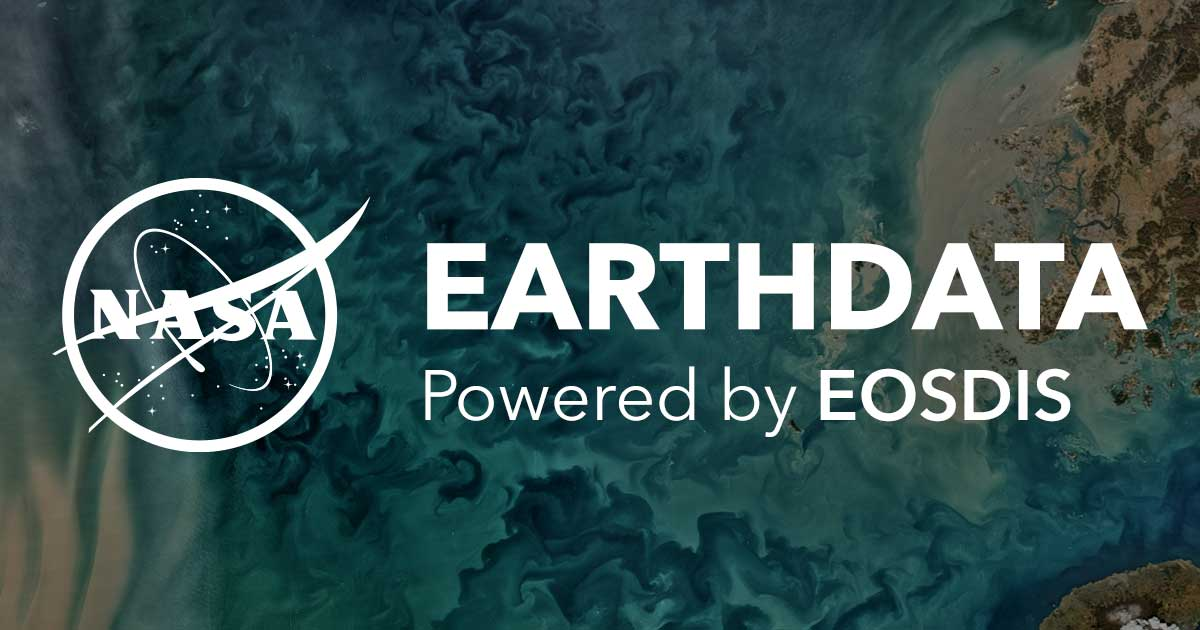

# <div style="text-align: center;">
  <h1><span style="color:blue; font-family:'Bodoni MT Black';">Web Scraping </span><span style="color:red; font-family:'Bodoni MT Black';">API </span><span style="color:white; font-family:'Bodoni MT Black';">NASA-EONET</span></h1>
</div>


<p><span style="color:black; font-family:'Bodoni MT Black'; font-size: 22px;">Mediante el uso de aplicaciones cliente, como Worldview de NASA EOSDIS, los usuarios pueden navegar por todo el mundo diariamente y buscar eventos naturales a medida que ocurren. Las tormentas se ven regularmente en los trópicos, tormentas de polvo sobre los desiertos, incendios forestales en los veranos. Estos eventos ocurren constantemente y las imágenes NRT de la NASA pueden representarlos todos utilizando una variedad de parámetros de datos diferentes. Sin embargo, la experiencia del usuario está personalizada y, por lo tanto, restringida por la aplicación del cliente.</span> </p> 

<p><span style="color:blue; font-family:'Bodoni MT Black'; font-size: 22px;">¿Qué pasaría si hubiera una API que proporcionara una lista seleccionada de eventos naturales y proporcionara una forma de vincular esos eventos a capas de imágenes NRT relacionadas con eventos? </span> Entra EONET.</p>

<p><span style="color:black; font-family:'Bodoni MT Black'; font-size: 22px;">El Rastreador de Eventos Naturales del Observatorio de la Tierra (<span style="color:red; font-family:'Bodoni MT Black'; font-size: 22px;">EONET</span>) es un servicio web prototipo con el objetivo de:</span></p>

<ul>
  <li><span style="color:red; font-family:'Bodoni MT Black'; font-size: 22px;">Proporcionar una fuente seleccionada de metadatos de eventos naturales continuamente actualizados;</span></li>
  <li><span style="color:red; font-family:'Bodoni MT Black'; font-size: 22px;">Proporcionar un servicio que vincule esos eventos naturales con fuentes de imágenes habilitadas para servicios web relacionadas temáticamente(por ejemplo, a través de WMS, WMTS, etc.). </span></ul>
     <p> Consulte la documentación de su API para obtener más información sobre cómo utilizar los servicios web de EONET.</p>

<p><span style="color:black; font-family:'Bodoni MT Black'; font-size: 22px;">El desarrollo de EONET comenzó en 2015 y ha sido apoyado por el Proyecto del Sistema de Información y Datos de Ciencias de la Tierra y el Observatorio de la Tierra (ESDIS) de la NASA.</span></p>




## <span style="color:white; font-family:'Bodoni MT Black';">Eventos Parametros </span>


|   NOMBRE    |                          DESCRIPCIÓN                           |
|-----------|--------------------------------------------------------------|
| identificación |           Identificación única para este evento.           |
|    título   |                   El título del evento.                      |
| descripción | Descripción opcional más larga del evento. Lo más probable es que sólo una frase o dos. |
|    enlace   |           El enlace completo al extremo de la API para este evento específico.          |
| categorías  |             Una o más categorías asignadas al evento.             |
|   fuentes   |       Una o más fuentes que remiten a más información sobre el evento.      |
| geometrías  | Una o más geometrías de eventos son el emparejamiento de una fecha/hora específica con una ubicación. Lo más probable es que la fecha/hora sea 00:00Z a menos que la fuente proporcione una hora en particular. La geometría será un objeto GeoJSON de tipo "Punto" o "Polígono". |
|   cerrado   | Un evento se considera “cerrado” cuando ha finalizado. El campo cerrado incluirá una fecha/hora en que finalizó el evento. Dependiendo de la naturaleza del evento, el valor cerrado puede o no representar con precisión el final absoluto del evento. |


### <span style="color:red; font-family:'Bodoni MT Black';">Categorias Parametros </span>

| Parámetro | Descripción                                                |
|-----------|------------------------------------------------------------|
| id        | ID único de la categoría. En este caso, es 10.              |
| title     | El título de la categoría. En este caso, es "Severe Storms".|

### <span style="color:red; font-family:'Bodoni MT Black';">Geometrías Parametros </span>

| Parámetro      | Descripción                                                                                                        |
|----------------|--------------------------------------------------------------------------------------------------------------------|
| date           | La fecha y hora asociadas a la geometría del evento. |
| type           | El tipo de geometría.                                                         |
| coordinates    | Las coordenadas geográficas del punto en forma de una matriz|

### <span style="color:red; font-family:'Bodoni MT Black';">Fuentes Parametros </span>



| Parámetro | Descripción                                                                                               |
|-----------|-----------------------------------------------------------------------------------------------------------|
| id        | ID único de la fuente. En el primer caso, es "GDACS". En el segundo caso, es "JTWC".                      |
| url       | La URL completa que proporciona más información sobre el evento. En el primer caso, es el enlace de GDACS. En el segundo caso, es el enlace de JTWC.|

# <span style="color:white; font-family:'Bodoni MT Black';">API </span>

In [124]:
# Librerias a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as ptl
import seaborn as sns
from urllib.request import urlopen
from bs4 import BeautifulSoup as soup
import requests
import json
import csv
import folium

In [125]:

url="https://eonet.gsfc.nasa.gov/api/v2.1/events"
uclient=urlopen(url)
responsehtml=uclient.read()
uclient.close()
#print(responsehtml.decode())
#type(responsehtml.decode())

In [126]:
data = responsehtml.decode()
info = json.loads(data)
#print(info)

In [127]:
# Convertir los datos JSON en un DataFrame de pandas
df = pd.DataFrame(info['events'])

# Separar los datos en columnas separadas
df['TÍTULO_CATEGORÍA'] = df['categories'].apply(lambda x: x[0]['title'])
df['ID_CATEGORÍA'] = df['categories'].apply(lambda x: x[0]['id'])

df['ID_FUENTE'] = df['sources'].apply(lambda x: x[0]['id'])
df['URL_FUENTE'] = df['sources'].apply(lambda x: x[0]['url'])

df['FECHA_GEOMETRÍA'] = df['geometries'].apply(lambda x: x[0]['date'])
df['TIPO_GEOMETRÍA'] = df['geometries'].apply(lambda x: x[0]['type'])
df['COORDENADAS_GEOMETRÍA'] = df['geometries'].apply(lambda x: [coord['coordinates'] for coord in x])

# Expandir la lista de coordenadas en múltiples filas
df = df.explode('COORDENADAS_GEOMETRÍA')

# Separar las coordenadas en latitud y longitud
df['LATITUD'] = df['COORDENADAS_GEOMETRÍA'].apply(lambda x: x[1])
df['LONGITUD'] = df['COORDENADAS_GEOMETRÍA'].apply(lambda x: x[0])

# Eliminar las columnas 
df.drop(['sources', 'geometries', 'categories','COORDENADAS_GEOMETRÍA'], axis=1, inplace=True)

# Renombrar las columnas
df.rename(columns={
    'id': 'ID',
    'title': 'TÍTULO',
    'description': 'DESCRIPCIÓN',
    'link': 'ENLACE',
    'TÍTULO_CATEGORÍA': 'CATEGORÍA_TÍTULO',
    'ID_CATEGORÍA': 'CATEGORÍA_ID',
    'ID_FUENTE': 'FUENTE_ID',
    'URL_FUENTE': 'FUENTE_URL',
    'FECHA_GEOMETRÍA': 'GEOMETRÍA_FECHA',
    'TIPO_GEOMETRÍA': 'GEOMETRÍA_TIPO',
    'FECHA': 'FECHA',
    'LATITUD': 'LATITUD',
    'LONGITUD': 'LONGITUD'
}, inplace=True)

# Guardar el DataFrame en un archivo CSV
df.to_csv('datoseventos.csv', encoding='UTF-8', index=False, quoting=csv.QUOTE_ALL)


# <span style="color:red; font-family:'Bodoni MT Black';">CATEGORIAS</span>

In [128]:
import json

data = responsehtml.decode()
info = json.loads(data)
#print(info)

In [129]:
cantidad_categorias = {}
ids_categorias = {}
for evento in info["events"]:
    for categoria in evento["categories"]:
        titulo_categoria = categoria["title"]
        id_categoria = categoria["id"]
        if titulo_categoria in cantidad_categorias:
            cantidad_categorias[titulo_categoria] += 1
        else:
            cantidad_categorias[titulo_categoria] = 1
        if id_categoria  in ids_categorias:
            ids_categorias[id_categoria] += 1
        else:
            ids_categorias[id_categoria] = 1

for categoria, cantidad in cantidad_categorias.items():
    print("Categoría:", categoria)
    print("Cantidad de eventos:", cantidad)
for IDs in ids_categorias.items():
    print("ID:", IDs)



Categoría: Severe Storms
Cantidad de eventos: 3
Categoría: Volcanoes
Cantidad de eventos: 26
Categoría: Sea and Lake Ice
Cantidad de eventos: 56
Categoría: Wildfires
Cantidad de eventos: 335
ID: (10, 3)
ID: (12, 26)
ID: (15, 56)
ID: (8, 335)


In [165]:
events = info['events']
Categoria = {}

# Iterar sobre los eventos
for event in events:
    title = event['title']
    categories = event['categories']

    # Iterar sobre las categorías del evento
    for category in categories:
        category_id = category['id']
        category_title = category['title']

        # Verificar si el DataFrame de la categoría ya existe
        if category_id not in Categoria:
            Categoria[category_id] = pd.DataFrame(columns=['TITULO', 'Enlace',"Geometria"])

        # Agregar el evento al DataFrame de la categoría
        Categoria[category_id] = pd.concat([
            Categoria[category_id],
            pd.DataFrame({
                'TITULO': [title],

                'Enlace': [event['link']],
                'Geometria':[event['geometries']]
                
            })
        ], ignore_index=True)

#for category_id, df in dataframes.items():
    #print('Categoría:', category_id)
    #print(df)
    #print()
    

In [166]:
TORMENTAS=Categoria.get(10)
VOLCANES_ACTIVOS=Categoria.get(12)
ICEBERG=Categoria.get(15)
INCENDIOS_FORESTALES=Categoria.get(8)

In [167]:
#TORMETAS SEVERAS
TORMENTAS['FECHA_GEOMETRÍA'] = TORMENTAS['Geometria'].apply(lambda x: x[0]['date'])
TORMENTAS['TIPO_GEOMETRÍA'] = TORMENTAS['Geometria'].apply(lambda x: x[0]['type'])
TORMENTAS['COORDENADAS_GEOMETRÍA'] = TORMENTAS['Geometria'].apply(lambda x: [coord['coordinates'] for coord in x])

# Expandir la lista de coordenadas en múltiples filas
TORMENTAS = TORMENTAS.explode('COORDENADAS_GEOMETRÍA')

# Separar las coordenadas en latitud y longitud
TORMENTAS['LATITUD'] = TORMENTAS['COORDENADAS_GEOMETRÍA'].apply(lambda x: x[1])
TORMENTAS['LONGITUD'] = TORMENTAS['COORDENADAS_GEOMETRÍA'].apply(lambda x: x[0])
#print(TORMENTAS)



In [168]:
#VOLCANES ACTIVOS
VOLCANES_ACTIVOS['FECHA_GEOMETRÍA'] = VOLCANES_ACTIVOS['Geometria'].apply(lambda x: x[0]['date'])
VOLCANES_ACTIVOS['TIPO_GEOMETRÍA'] = VOLCANES_ACTIVOS['Geometria'].apply(lambda x: x[0]['type'])
VOLCANES_ACTIVOS['COORDENADAS_GEOMETRÍA'] = VOLCANES_ACTIVOS['Geometria'].apply(lambda x: [coord['coordinates'] for coord in x])

# Expandir la lista de coordenadas en múltiples filas
VOLCANES_ACTIVOS = VOLCANES_ACTIVOS.explode('COORDENADAS_GEOMETRÍA')

# Separar las coordenadas en latitud y longitud
VOLCANES_ACTIVOS['LATITUD'] = VOLCANES_ACTIVOS['COORDENADAS_GEOMETRÍA'].apply(lambda x: x[1])
VOLCANES_ACTIVOS['LONGITUD'] = VOLCANES_ACTIVOS['COORDENADAS_GEOMETRÍA'].apply(lambda x: x[0])
#print(VOLCANES_ACTIVOS)

In [169]:
#ICEBERG
ICEBERG['FECHA_GEOMETRÍA'] = ICEBERG['Geometria'].apply(lambda x: x[0]['date'])
ICEBERG['TIPO_GEOMETRÍA'] = ICEBERG['Geometria'].apply(lambda x: x[0]['type'])
ICEBERG['COORDENADAS_GEOMETRÍA'] = ICEBERG['Geometria'].apply(lambda x: [coord['coordinates'] for coord in x])

# Expandir la lista de coordenadas en múltiples filas
ICEBERG = ICEBERG.explode('COORDENADAS_GEOMETRÍA')

# Separar las coordenadas en latitud y longitud
ICEBERG['LATITUD'] = ICEBERG['COORDENADAS_GEOMETRÍA'].apply(lambda x: x[1])
ICEBERG['LONGITUD'] = ICEBERG['COORDENADAS_GEOMETRÍA'].apply(lambda x: x[0])

#print(ICEBERG)

In [170]:
#INCENDIOS FORESTALES
INCENDIOS_FORESTALES['FECHA_GEOMETRÍA'] = INCENDIOS_FORESTALES['Geometria'].apply(lambda x: x[0]['date'])
INCENDIOS_FORESTALES['TIPO_GEOMETRÍA'] = INCENDIOS_FORESTALES['Geometria'].apply(lambda x: x[0]['type'])
INCENDIOS_FORESTALES['COORDENADAS_GEOMETRÍA'] = INCENDIOS_FORESTALES['Geometria'].apply(lambda x: [coord['coordinates'] for coord in x])

# Expandir la lista de coordenadas en múltiples filas
INCENDIOS_FORESTALES = INCENDIOS_FORESTALES.explode('COORDENADAS_GEOMETRÍA')

# Separar las coordenadas en latitud y longitud
INCENDIOS_FORESTALES['LATITUD'] = INCENDIOS_FORESTALES['COORDENADAS_GEOMETRÍA'].apply(lambda x: x[1])
INCENDIOS_FORESTALES['LONGITUD'] = INCENDIOS_FORESTALES['COORDENADAS_GEOMETRÍA'].apply(lambda x: x[0])
#print(INCENDIOS_FORESTALES)

# <span style="color:blue; font-family:'Bodoni MT Black';">MAPAS</span>

In [174]:
#pip install folium
import folium
from folium.plugins import MarkerCluster, HeatMap

In [176]:
mapa = folium.Map()

# Crear el grupo de marcadores para la pestaña 1
grupo_marcadores_1 = folium.FeatureGroup(name='Tormentas severas')

# Agregar marcadores al mapa
for index, row in TORMENTAS.iterrows():
    grupo_marcadores_1.add_child(folium.Marker([row['LATITUD'], row['LONGITUD']], popup=row['TITULO'])).add_to(mapa)

# Crear el grupo de marcadores para la pestaña 2
grupo_marcadores_2 = folium.FeatureGroup(name='Volcanes Activos')

# Agregar marcadores al grupo de marcadores 2
for index, row in VOLCANES_ACTIVOS.iterrows():
    grupo_marcadores_2.add_child(folium.Marker([row['LATITUD'], row['LONGITUD']], popup=row['TITULO'])).add_to(mapa)

# Crear el grupo de marcadores para la pestaña 3
grupo_marcadores_3 = folium.FeatureGroup(name='Iceberg')

for index, row in ICEBERG.iterrows():
    grupo_marcadores_3.add_child(folium.Marker([row['LATITUD'], row['LONGITUD']], popup=row['TITULO'])).add_to(mapa)

# Crear el grupo de marcadores para la pestaña 4
grupo_marcadores_4 = folium.FeatureGroup(name='Incendios Forrestales')

for index, row in INCENDIOS_FORESTALES.iterrows():
    grupo_marcadores_4.add_child(folium.Marker([row['LATITUD'], row['LONGITUD']], popup=row['TITULO'])).add_to(mapa)

# Agregar los grupos de marcadores al mapa
mapa.add_child(grupo_marcadores_1)
mapa.add_child(grupo_marcadores_2)
mapa.add_child(grupo_marcadores_3)
mapa.add_child(grupo_marcadores_4)

# Crear el control de capas para las pestañas
control_capas = folium.LayerControl()

# Agregar el control de capas al mapa
mapa.add_child(control_capas)

# Mostrar el mapa
display(mapa)
mapa.save("Mapas_Eventos.html")